In [ ]:
#Used these sources:
#https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#https://github.com/dvschultz/ai/blob/master/StyleGAN2.ipynb
#https://github.com/pytorch/examples/issues/70
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb
#https://github.com/soumith/dcgan.torch/issues/2#issuecomment-283982237
#https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/
#https://github.com/soumith/ganhacks
#https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4

#Used this dataset:
#https://www.kaggle.com/puneet6060/intel-image-classification#20142.jpg

import time
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

# Set random seem for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8098


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Root directory for project
rootdir = "/content/drive/My Drive/Landscape GAN/"

#Saved model directory
modeldir = os.path.join(rootdir, "models")

# Root directory for images
dataroot = os.path.join(rootdir, "data")

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 150

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

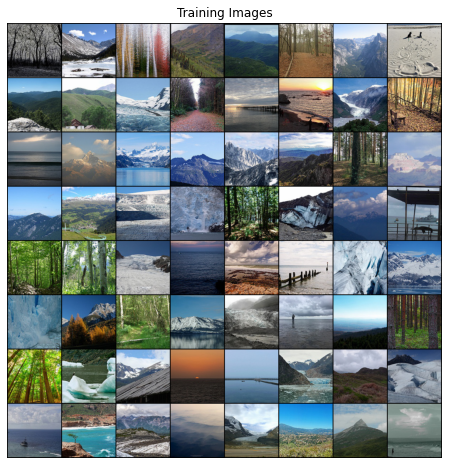

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__() #Inherits from nn.Module
        self.ngpu = ngpu #Number of GPUS
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False), #Convolutional layer, forms "many to one" relationship, shrinks down information to 4x4 matrix
            nn.BatchNorm2d(ngf * 16), #Prevents internal covariate shift: https://machinelearning.wtf/terms/internal-covariate-shift/
            nn.ReLU(True), #Activation function
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), #Upsampled by this point, transposed convolution, reason for checkerboard artifacts
            nn.Tanh() #New activation function, returns (-1, 1)
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [ ]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Adding gaussian noise to input layer to help stabilize learning
            GaussianNoise(),
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid() #After convoluting to a 4x4 image, finally return a value from (0, 1) using the sigmoid function
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): GaussianNoise()
    (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Batch

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss() #Measures binary cross entropy between target and output, aka log loss, uses logarithmic function to bias against outputs that are way off

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) #Adam: Optimizer that uses adaptive learning rates for different parameters
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) #based on the squared gradients and the momentum of the gradients by looking at their moving average

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Nicely formatted time string -- Thanks Jeff Heaton
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

print("Starting Training Loop...")

# For each epoch
start = time.time()

last_epoch = start

for epoch in range(num_epochs):
    epoch_start = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            elapsed = time.time()-start
            epoch_elapsed = time.time()-last_epoch
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tEpoch_Length: %s\tElapsed: %s'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, hms_string(epoch_elapsed), hms_string(elapsed)))
            last_epoch = time.time()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/150][0/74]	Loss_D: 1.6710	Loss_G: 6.6868	D(x): 0.7389	D(G(z)): 0.6628 / 0.0022	Epoch_Length: 0:01:27.51	Elapsed: 0:01:27.51
[0/150][50/74]	Loss_D: 1.5476	Loss_G: 7.1613	D(x): 0.4264	D(G(z)): 0.0782 / 0.0010	Epoch_Length: 0:17:02.61	Elapsed: 0:18:30.13
[1/150][0/74]	Loss_D: 2.4606	Loss_G: 2.3070	D(x): 0.7677	D(G(z)): 0.8647 / 0.1243	Epoch_Length: 0:08:14.12	Elapsed: 0:26:44.25
[1/150][50/74]	Loss_D: 1.4408	Loss_G: 1.6399	D(x): 0.4445	D(G(z)): 0.3508 / 0.2217	Epoch_Length: 0:00:24.35	Elapsed: 0:27:08.61
[2/150][0/74]	Loss_D: 1.4763	Loss_G: 1.1999	D(x): 0.6240	D(G(z)): 0.5883 / 0.3388	Epoch_Length: 0:00:12.79	Elapsed: 0:27:21.40
[2/150][50/74]	Loss_D: 0.9328	Loss_G: 2.9119	D(x): 0.6013	D(G(z)): 0.2876 / 0.1020	Epoch_Length: 0:00:24.43	Elapsed: 0:27:45.84
[3/150][0/74]	Loss_D: 0.8481	Loss_G: 2.2617	D(x): 0.6307	D(G(z)): 0.2263 / 0.1178	Epoch_Length: 0:00:12.87	Elapsed: 0:27:58.71
[3/150][50/74]	Loss_D: 1.0768	Loss_G: 1.9857	D(x): 0.6473	D(G(z)): 0.3926 / 0.1682	Epoch_Length: 0:00:24.53	

In [ ]:
#Save model
from datetime import datetime
modelname = f"{manualSeed}_{num_epochs}_{image_size}.pt"
modelpath = os.path.join(modeldir, modelname)
torch.save(netG, modelpath)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


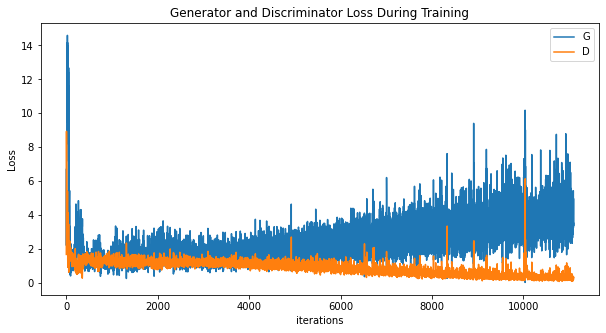

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
#Did this all myself too, woo!

imgdir = os.path.join(rootdir, 'images')
newimgs = os.path.join(imgdir, f'{batch_size}_{num_epochs}_{manualSeed}')

if not os.path.exists(newimgs): os.mkdir(newimgs)

for n, i in enumerate(img_list):
  imstr = "/{}/{}.png".format(newimgs, n)
  imgpath = os.path.join(imgdir, imstr)
  vutils.save_image(i, imgpath)

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Test/Continue training existing model

In [ ]:
#Load existing model
#Model class must be defined somewhere
manualSeed = 2701
num_epochs = 150
image_size = 128

modelname = f"{manualSeed}_{num_epochs}_{image_size}.pt"
modelpath = os.path.join(modeldir, modelname)
model = torch.load(modelpath)
model.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

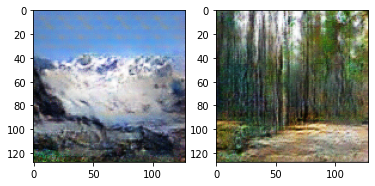

In [ ]:
seed1 = 244
seed2 = 987
 
 
def generate_images(net, noise, out_list):
 for i in noise:
   new_fake = net(i).cpu().detach()
   original = np.transpose(new_fake[-1],(1,2,0))
   normalized = vutils.make_grid(original, padding=None, normalize=True)
   out_list.append(normalized)

seeds = []
steps = 60
 
torch.manual_seed(seed1)
seeds.append(torch.randn(1, nz, 1, 1, device=device))
 
torch.manual_seed(seed2)
seeds.append(torch.randn(1, nz, 1, 1, device=device))
 
diff = seeds[1] - seeds[0]
step = diff / steps
 
current = seeds[0]
 
transition_seeds = []
 
for i in range(steps):
 transition_seeds.append(current)
 current = current + step
 
im_list = []
generate_images(model, transition_seeds, im_list)
 
 
test_list = []
generate_images(model, seeds, test_list)
 
f, axarr = plt.subplots(1,2)
axarr[0].imshow(test_list[0])
axarr[1].imshow(test_list[1])

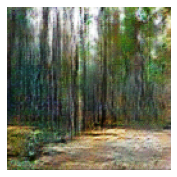

In [ ]:
#%%capture
fig = plt.figure(figsize=(3,3))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in im_list]
ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000, blit=True)
 
HTML(ani.to_jshtml())

In [ ]:
imgdir = os.path.join(rootdir, 'images')
newimgs = os.path.join(imgdir, f'{batch_size}_{num_epochs}_{manualSeed}')
transitiondir = os.path.join(newimgs, f'transition/{seed1}to{seed2}/')
 
if not os.path.exists(transitiondir): os.mkdir(transitiondir)
 
for n, i in enumerate(im_list):
 imstr = "/{}/{}.png".format(transitiondir, n)
 converted = (i.numpy()*255).astype(np.uint8)
 im = Image.fromarray(converted)
 im.save(imstr)
 
#Use ffmpeg -i %d.png -vcodec mpeg4 mov.mp4 to make these images into a movie